##### Импорт библиотек

In [1]:
import requests as r
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import plotly as pt
import plotly.express as px


##### Задание 3

In [2]:
#Подавление ошибки цепного назначения
pd.options.mode.chained_assignment = None

#Раскрываем все строки и столбцы
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Запрашиваем данные через GET запрос и преобразуем в json
visits_json = r.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01').json()
registrations_json = r.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01').json()

#Преобразовываем json в DataFrame
visits = pd.DataFrame(visits_json)
registrations = pd.DataFrame(registrations_json)

#Добавляем столбец с датой
visits['date'] = pd.to_datetime(visits['datetime']).dt.date
registrations['date'] = pd.to_datetime(registrations['datetime']).dt.date

#Маркируем ботов
visits['is_bot'] = np.where(visits['user_agent'].str.contains('bot'), 'yes', 'no')



In [30]:
#Группируем и объединяем данные
visits_and_registrations = pd.concat([
    visits[visits['is_bot'] == 'no'].groupby(['date', 'platform']).agg({'visit_id': 'count'}),
    registrations.groupby(['date', 'platform']).agg({'user_id': 'count'})
], axis = 1).reset_index()

#Переименовываем столбцы и заполняем нули
visits_and_registrations.rename(columns = {'visit_id':'visits', 'user_id':'registrations'}, inplace = True )
visits_and_registrations['registrations'] = visits_and_registrations['registrations'].fillna(0)

#Считаем конверсию
visits_and_registrations['conversion'] = round(visits_and_registrations['registrations']/visits_and_registrations['visits']*100, 0)

#Сохраняем в формате json
# visits_and_registrations.to_json('conversion.json', orient = 'columns')

print(visits_and_registrations.head(10))


         date platform  visits  registrations  conversion
0  2023-03-01  android     264            218        83.0
1  2023-03-01      ios      78             67        86.0
2  2023-03-01      web    2123             78         4.0
3  2023-03-02  android     106             91        86.0
4  2023-03-02      ios     103             76        74.0
5  2023-03-02      web    2039             52         3.0
6  2023-03-03  android     251            218        87.0
7  2023-03-03      ios      57             54        95.0
8  2023-03-03      web    3612             66         2.0
9  2023-03-04  android     193            119        62.0


##### Задание 4

In [8]:
#Читаем данные из csv файла
ads_info = pd.read_csv('ads.csv')

#Добавляем столбец с датой
ads_info['date_ymd'] = pd.to_datetime(ads_info['date']).dt.date

#Группируем по дате и рекламной компании, находим стоимость рекламных кампаний по дням
ads_grouped = ads_info.groupby(['date_ymd', 'utm_campaign']).agg({'cost':'sum'}).reset_index()

#Соединяем таблицу конверсий и рекламы, переименовываем столбцы
ads = visits_and_registrations.merge(ads_grouped, left_on = 'date', right_on = 'date_ymd', how = 'left') 
ads = ads[['date', 'visits', 'registrations', 'cost', 'utm_campaign']]
ads.rename(columns = {'date':'date_group'}, inplace = True )
ads['cost'] = ads['cost'].fillna(0)
ads['utm_campaign'] = ads['utm_campaign'].fillna('none')

#Сохраняем в формате json
ads.to_json('ads.json', orient = 'columns')
print(ads.head(20))
# print(visits_and_registrations.head(200))
# print(ads_grouped.head(10))


    date_group  visits  registrations   cost              utm_campaign
0   2023-03-01     264            218  238.0  virtual_reality_workshop
1   2023-03-01      78             67  238.0  virtual_reality_workshop
2   2023-03-01    2123             78  238.0  virtual_reality_workshop
3   2023-03-02     106             91  164.0  virtual_reality_workshop
4   2023-03-02     103             76  164.0  virtual_reality_workshop
5   2023-03-02    2039             52  164.0  virtual_reality_workshop
6   2023-03-03     251            218  240.0  virtual_reality_workshop
7   2023-03-03      57             54  240.0  virtual_reality_workshop
8   2023-03-03    3612             66  240.0  virtual_reality_workshop
9   2023-03-04     193            119  167.0  virtual_reality_workshop
10  2023-03-04     117             86  167.0  virtual_reality_workshop
11  2023-03-04    4178             73  167.0  virtual_reality_workshop
12  2023-03-05     287            209  268.0  virtual_reality_workshop
13  20

##### Задание 5

###### *Итоговые визиты*

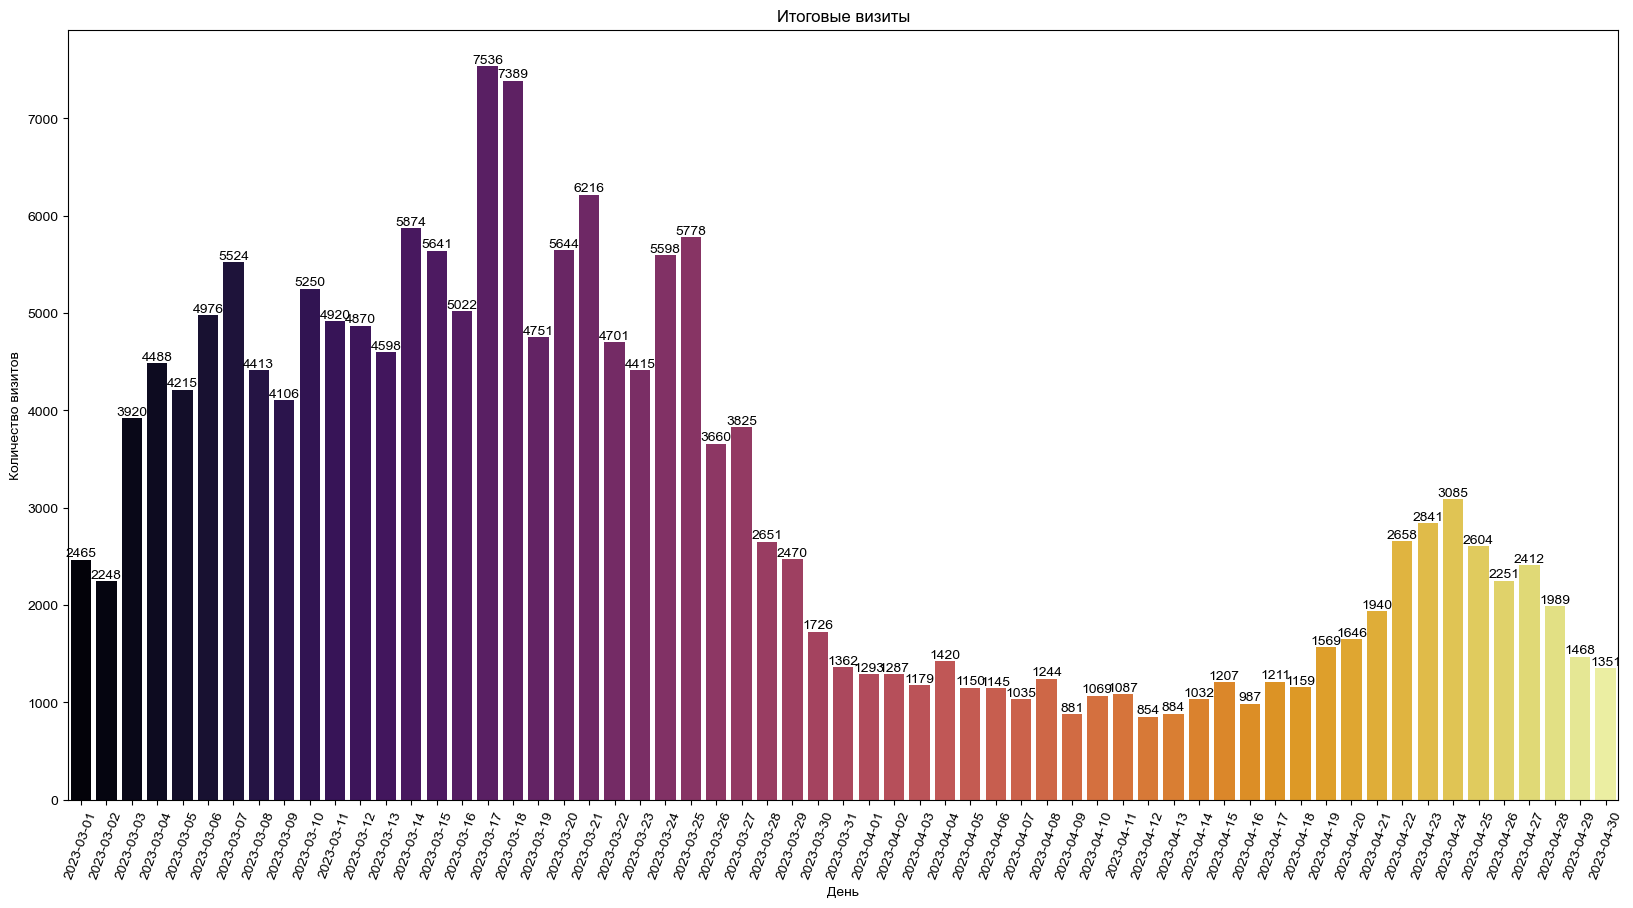

In [9]:
total_visits = ads[ads['date_group'] <= dt.date(2023, 4, 30)].groupby(['date_group']).agg({'visits':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x='date_group', y='visits', data=total_visits, palette = 'inferno')
ax.bar_label(ax.containers[0], fontsize=10)
sns.set_style("white")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Количество визитов')
plt.title('Итоговые визиты')
plt.show()








###### *Итоговые визиты с разбивкой по платформам*

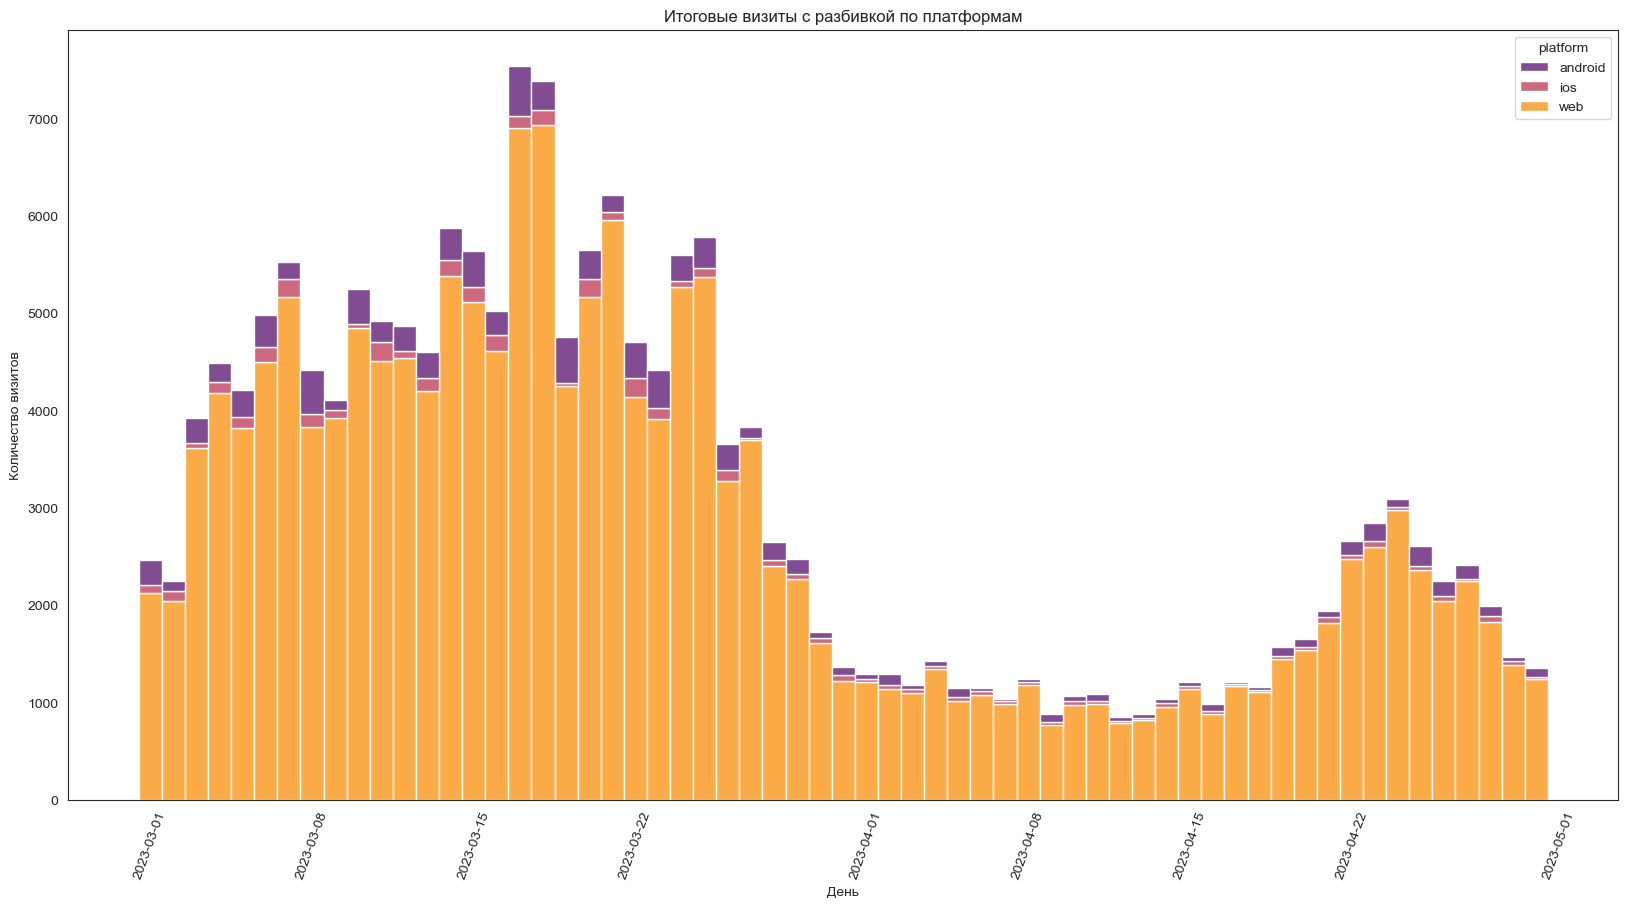

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date', weights='visits', hue = 'platform', data=visits_and_registrations[visits_and_registrations['date'] <= dt.date(2023, 4, 30)], palette = 'inferno', multiple='stack')
sns.set_style("whitegrid")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Количество визитов')
plt.title('Итоговые визиты с разбивкой по платформам')
plt.show()






###### *Итоговые регистрации*

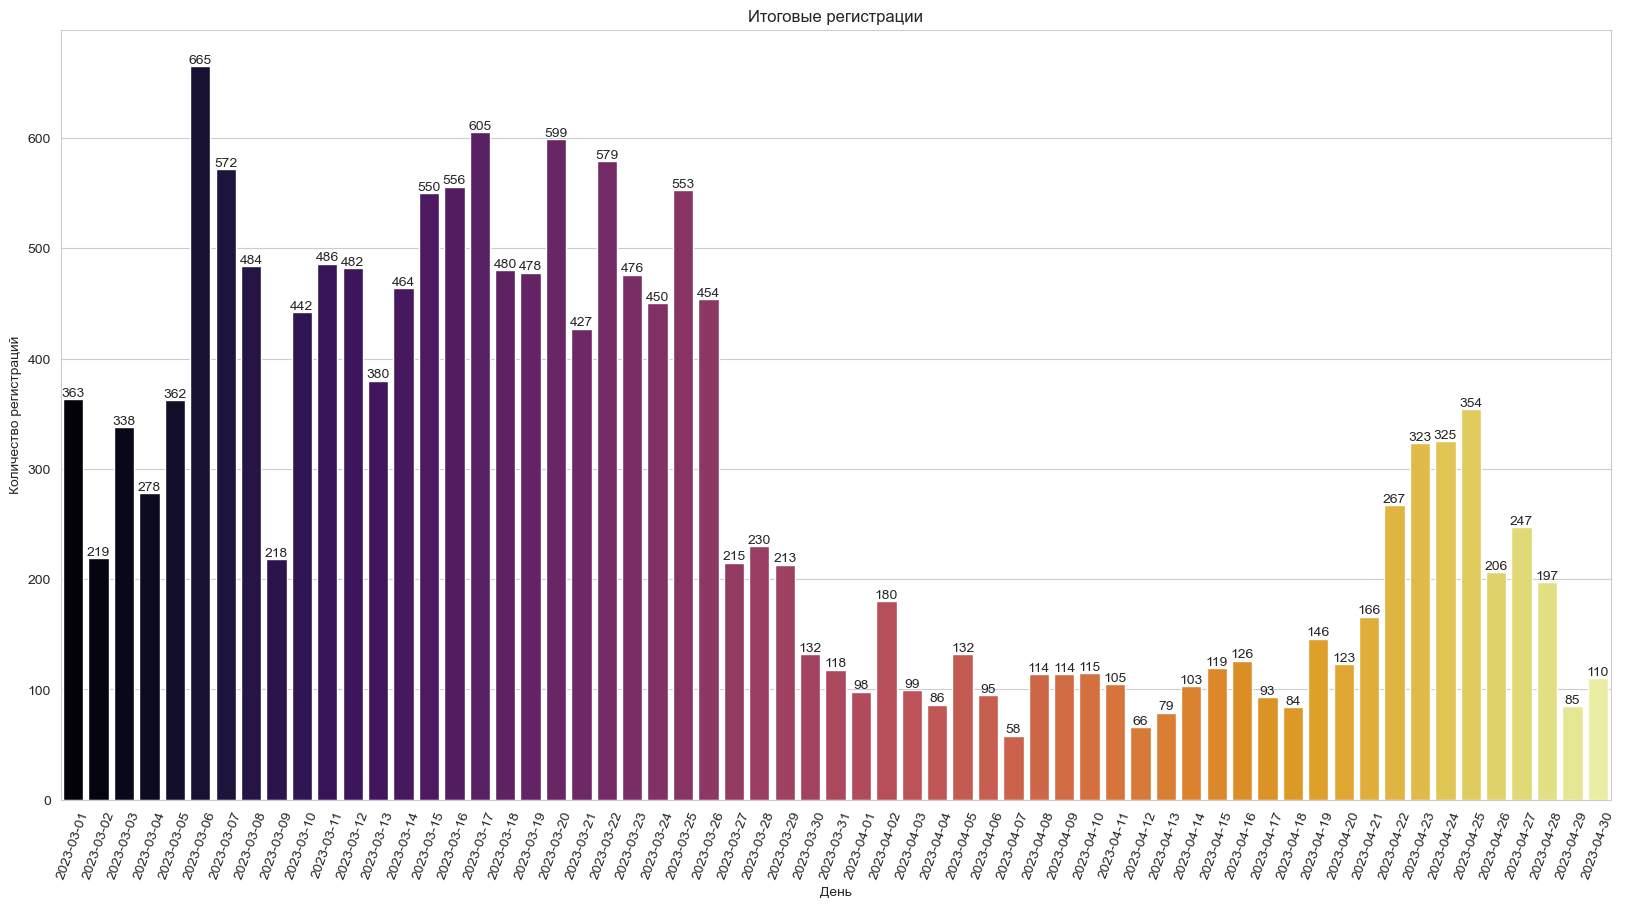

In [11]:
total_registrations = ads[ads['date_group'] <= dt.date(2023, 4, 30)].groupby(['date_group']).agg({'registrations':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x='date_group', y='registrations', data=total_registrations, palette = 'inferno')
ax.bar_label(ax.containers[0], fontsize=10)
sns.set_style("white")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Количество регистраций')
plt.title('Итоговые регистрации')
plt.show()


###### *Итоговые регистрации с разбивкой по платформе*

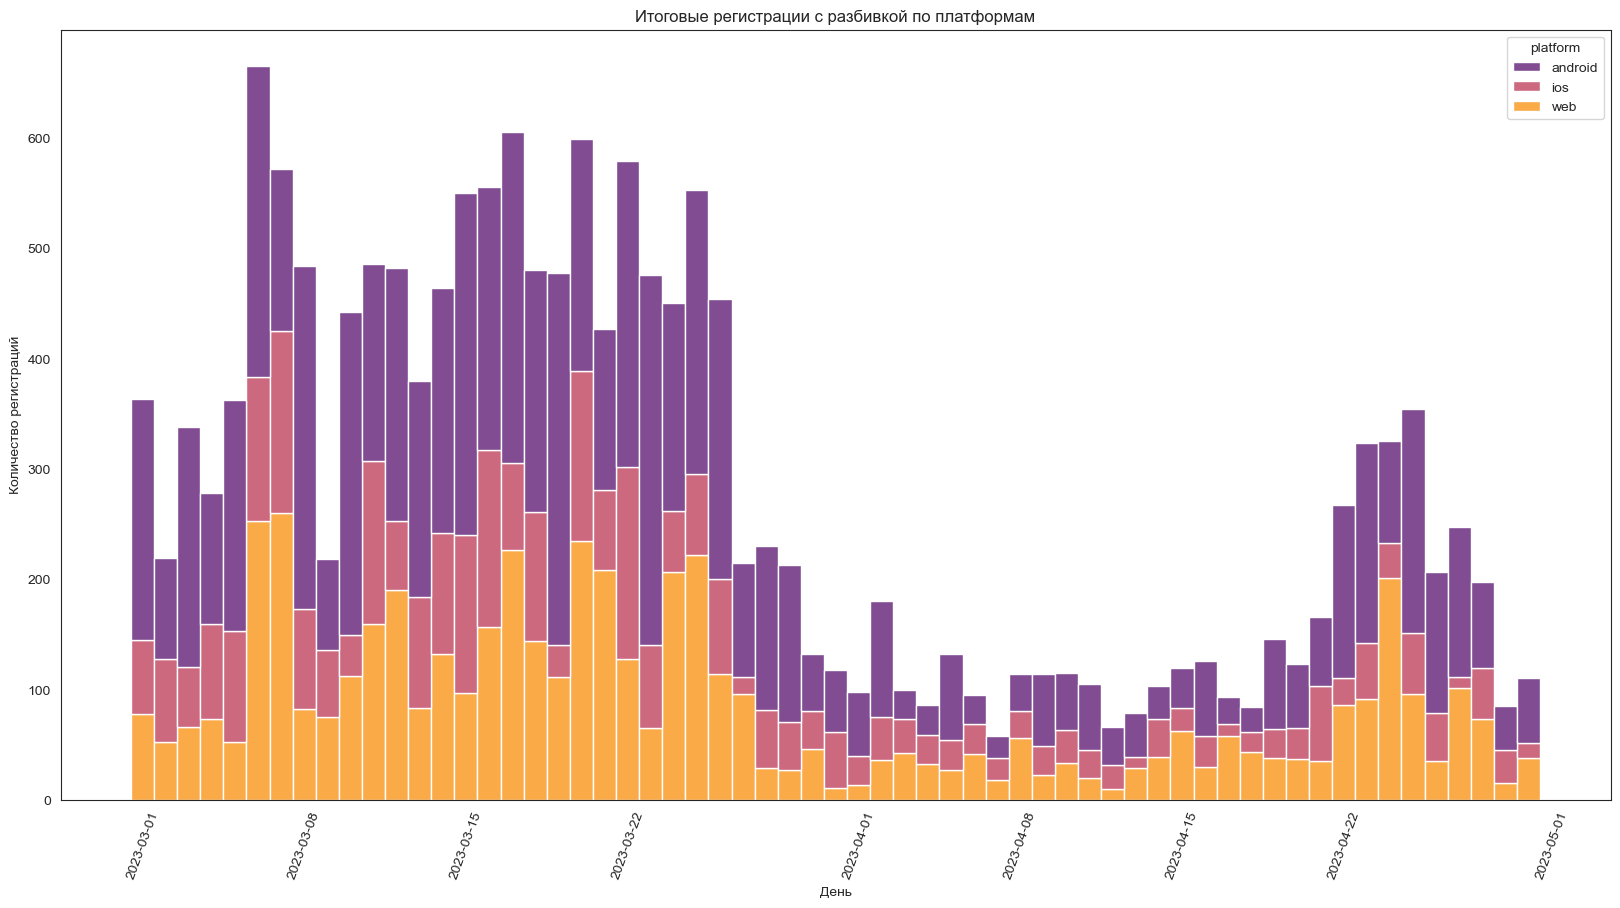

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date', weights='registrations', hue = 'platform', data=visits_and_registrations[visits_and_registrations['date'] <= dt.date(2023, 4, 30)], palette = 'inferno', multiple='stack')
sns.set_style("whitegrid")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Количество регистраций')
plt.title('Итоговые регистрации с разбивкой по платформам')
plt.show()


###### *Итоговые регистрации с разбивкой по типу регистрации*

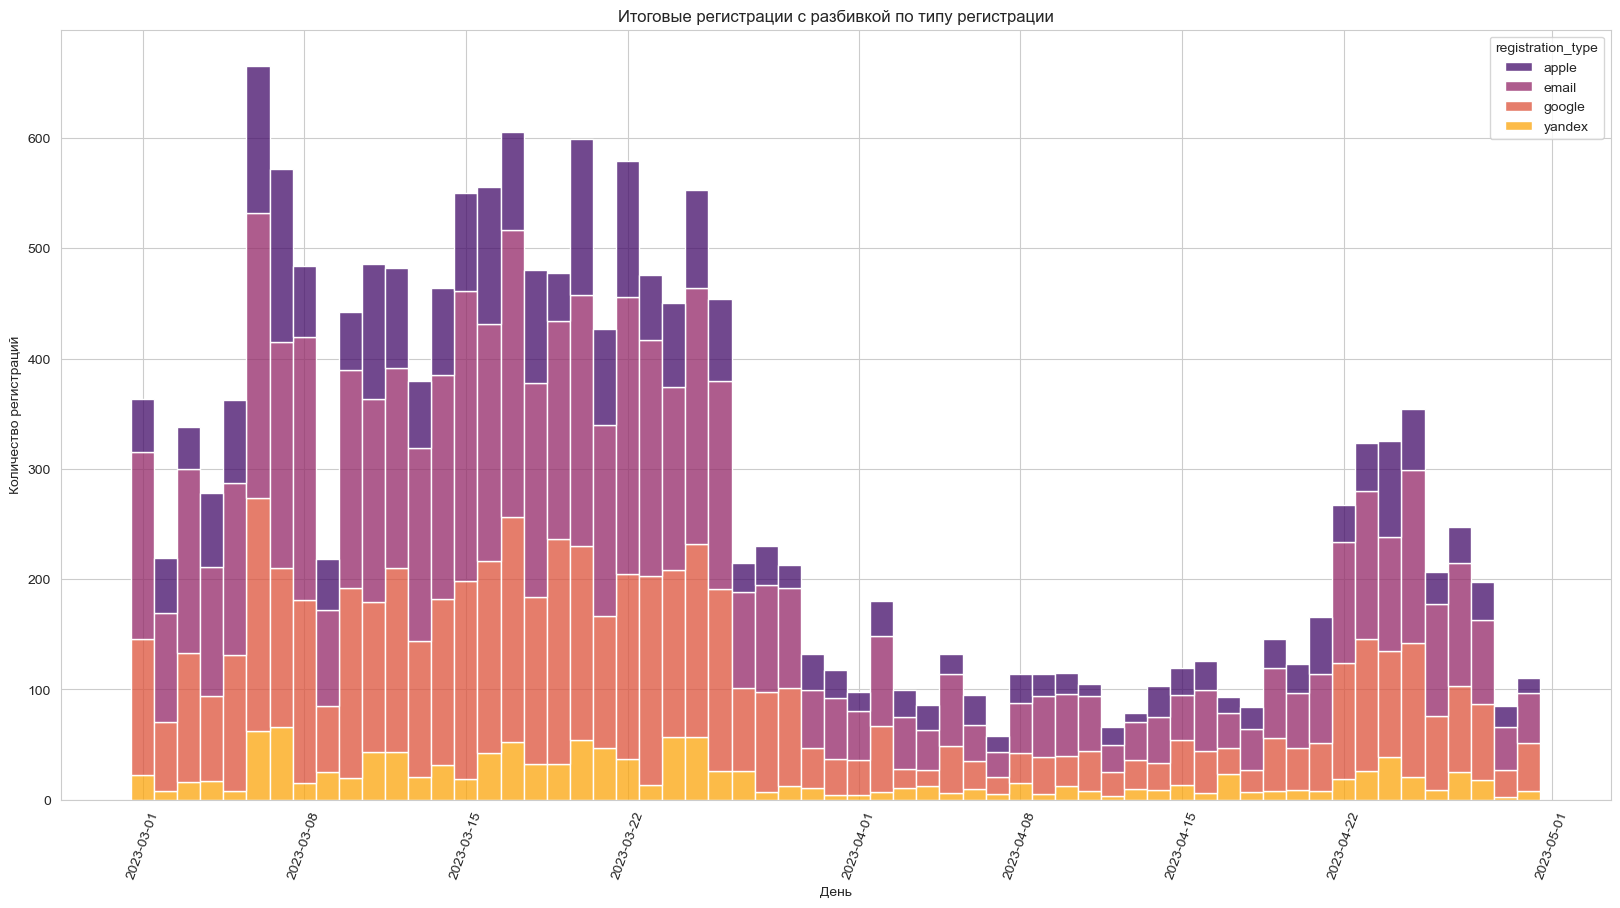

In [13]:
reg_types = registrations.groupby(['date', 'registration_type']).agg({'user_id':'count'}).reset_index()
reg_types.rename(columns = {'user_id':'count'}, inplace = True )

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='date', weights='count', hue = 'registration_type', data=reg_types[reg_types['date'] <= dt.date(2023, 4, 30)], palette = 'inferno', multiple='stack')
sns.set_style("whitegrid")
plt.xticks(rotation=70)
plt.xlabel('День')
plt.ylabel('Количество регистраций')
plt.title('Итоговые регистрации с разбивкой по типу регистрации')
plt.show()


###### *Итоговые регистрации с разбивкой по платформе - pie chart*

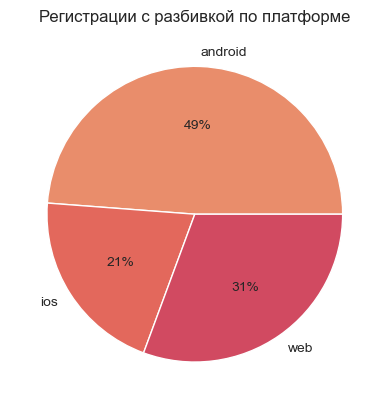

In [14]:
platforms_pie_info = visits_and_registrations.groupby(['platform']).agg({'registrations':'sum'}).reset_index()

colors = sns.color_palette('flare')[ 0:100 ]
plt.pie(platforms_pie_info['registrations'], labels = platforms_pie_info['platform'], colors = colors, autopct='%.0f%%')
plt.title('Регистрации с разбивкой по платформе')
plt.show()

###### *Итоговые регистрации с разбивкой по типу регистрации - pie chart*

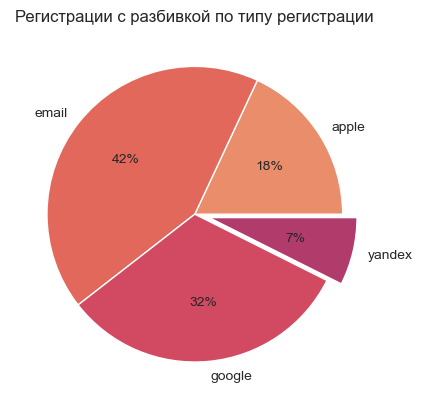

In [15]:
types_pie_info = reg_types.groupby(['registration_type']).agg({'count':'sum'}).reset_index()

colors = sns.color_palette('flare')[ 0:100 ]
plt.pie(types_pie_info['count'], labels = types_pie_info['registration_type'], colors = colors, autopct='%.0f%%', explode = [0, 0, 0, 0.1])
plt.title('Регистрации с разбивкой по типу регистрации')
plt.show()

###### *Итоговые конверсии*

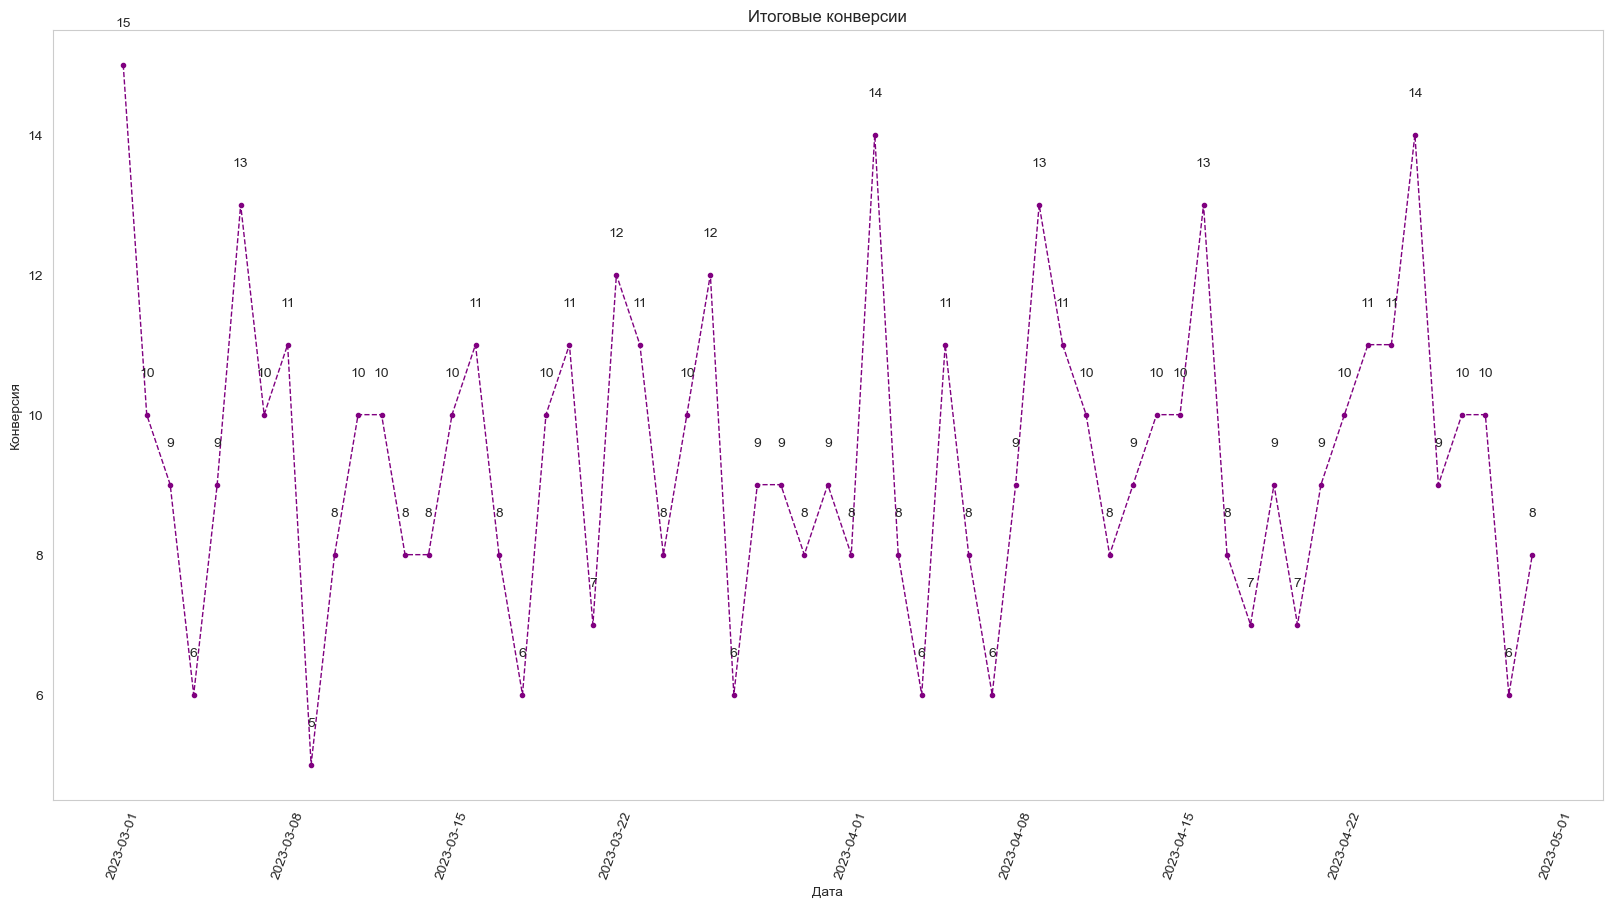

In [16]:
visits_per_day = visits_and_registrations.groupby(['date']).agg({'visits':'sum'})
registrations_per_day = visits_and_registrations.groupby(['date']).agg({'registrations':'sum'})
total_conversion = round(registrations_per_day['registrations']/visits_per_day['visits']*100, 0).reset_index()
total_conversion = total_conversion.set_axis(['date', 'conversion'], axis=1, copy = False)
total_conversion_two_months = total_conversion[total_conversion['date'] <= dt.date(2023, 4, 30)]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(total_conversion_two_months['date'], total_conversion_two_months['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Конверсия')
plt.title('Итоговые конверсии')
plt.xticks(rotation=70)
for x, y in zip(total_conversion_two_months['date'], total_conversion_two_months['conversion']):
    plt.text(x, y + 0.5, '%d' % y, ha='center', va = 'bottom')
plt.show()




###### *Итоговые конверсии Android*

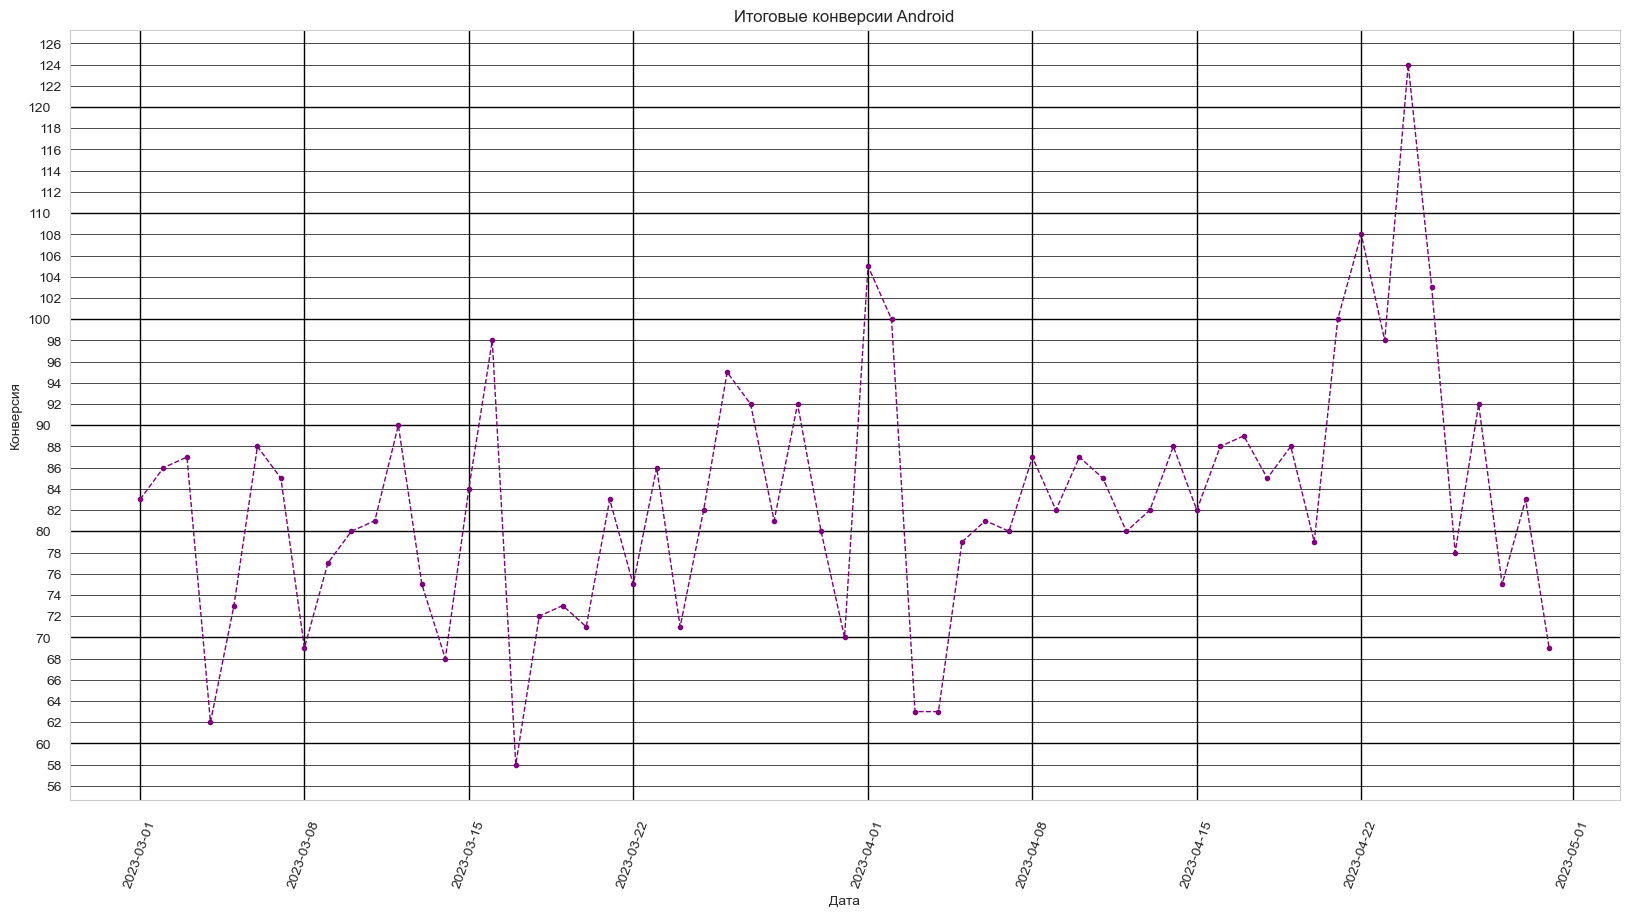

In [21]:
visits_and_registrations_android = visits_and_registrations[visits_and_registrations['platform'] == 'android']
visits_and_registrations_android_two_months = visits_and_registrations_android[visits_and_registrations_android['date'] <= dt.date(2023, 4, 30)]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(visits_and_registrations_android_two_months['date'], visits_and_registrations_android_two_months['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Конверсия')
plt.title('Итоговые конверсии Android')
plt.xticks(rotation=70)
plt.grid()

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter('{x:.0f}')

ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=2, )

# for x, y in zip(total_conversion_two_months['date'], total_conversion_two_months['conversion']):
#     plt.text(x, y + 50, '%d' % y, ha='center', va = 'bottom')
plt.show()

###### *Итоговые конверсии Ios*

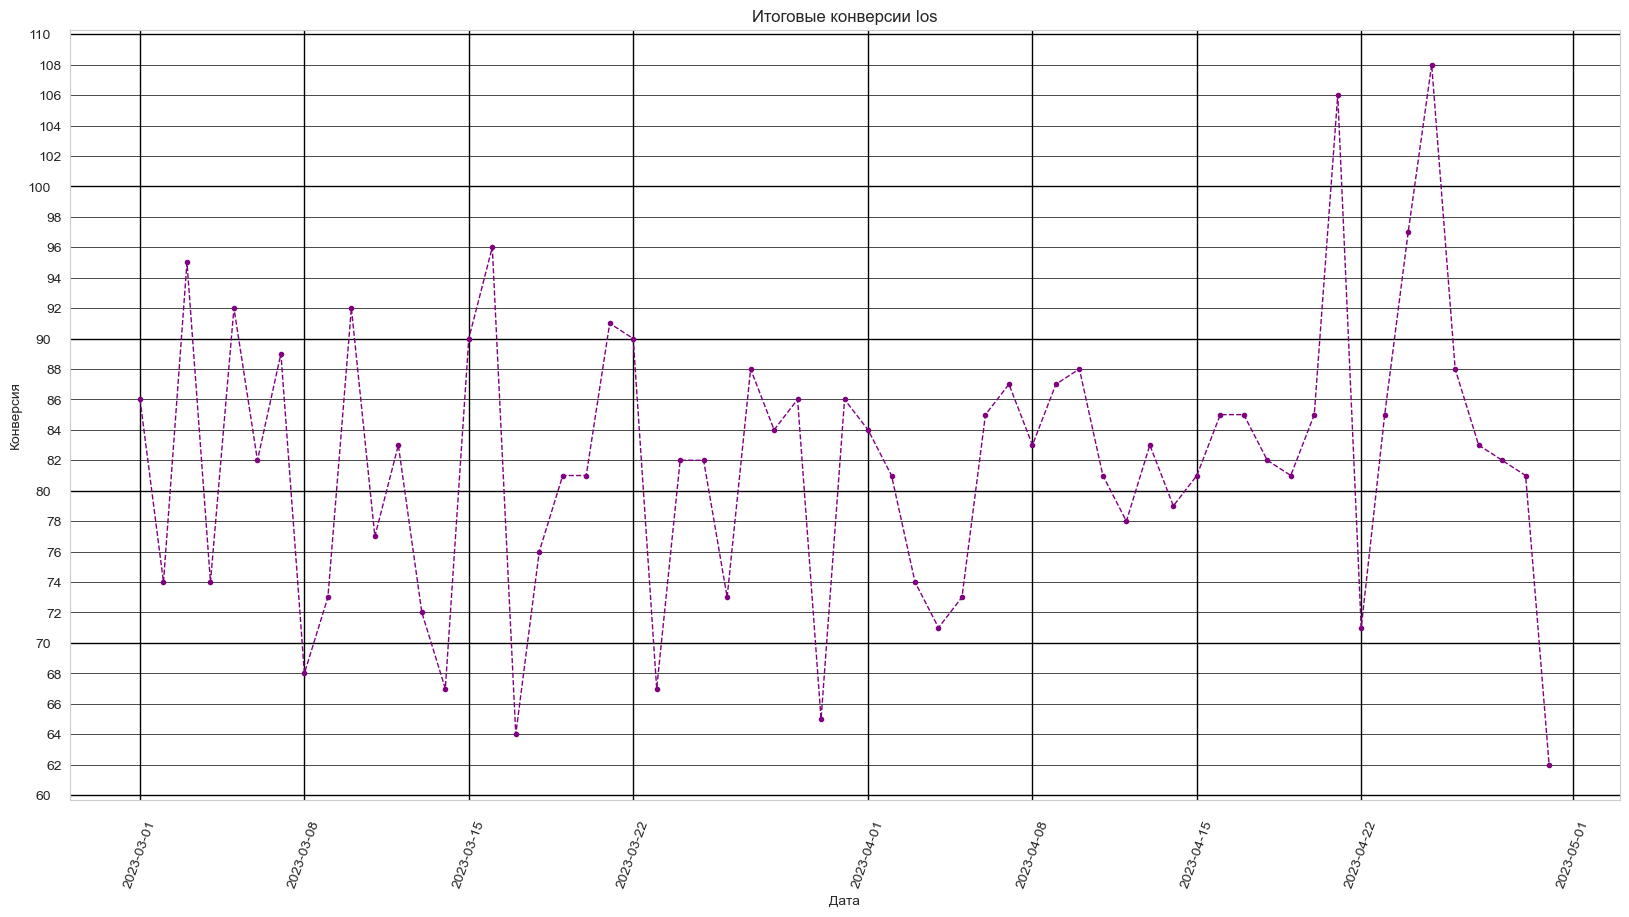

In [22]:
visits_and_registrations_ios = visits_and_registrations[visits_and_registrations['platform'] == 'ios']
visits_and_registrations_ios_two_months = visits_and_registrations_ios[visits_and_registrations_ios['date'] <= dt.date(2023, 4, 30)]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(visits_and_registrations_ios_two_months['date'], visits_and_registrations_ios_two_months['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Конверсия')
plt.title('Итоговые конверсии Ios')
plt.xticks(rotation=70)

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter('{x:.0f}')

ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=2, )

# for x, y in zip(total_conversion_two_months['date'], total_conversion_two_months['conversion']):
#     plt.text(x, y, '%d' % y, ha='center', va = 'bottom')
plt.show()

###### *Итоговые конверсии Web*

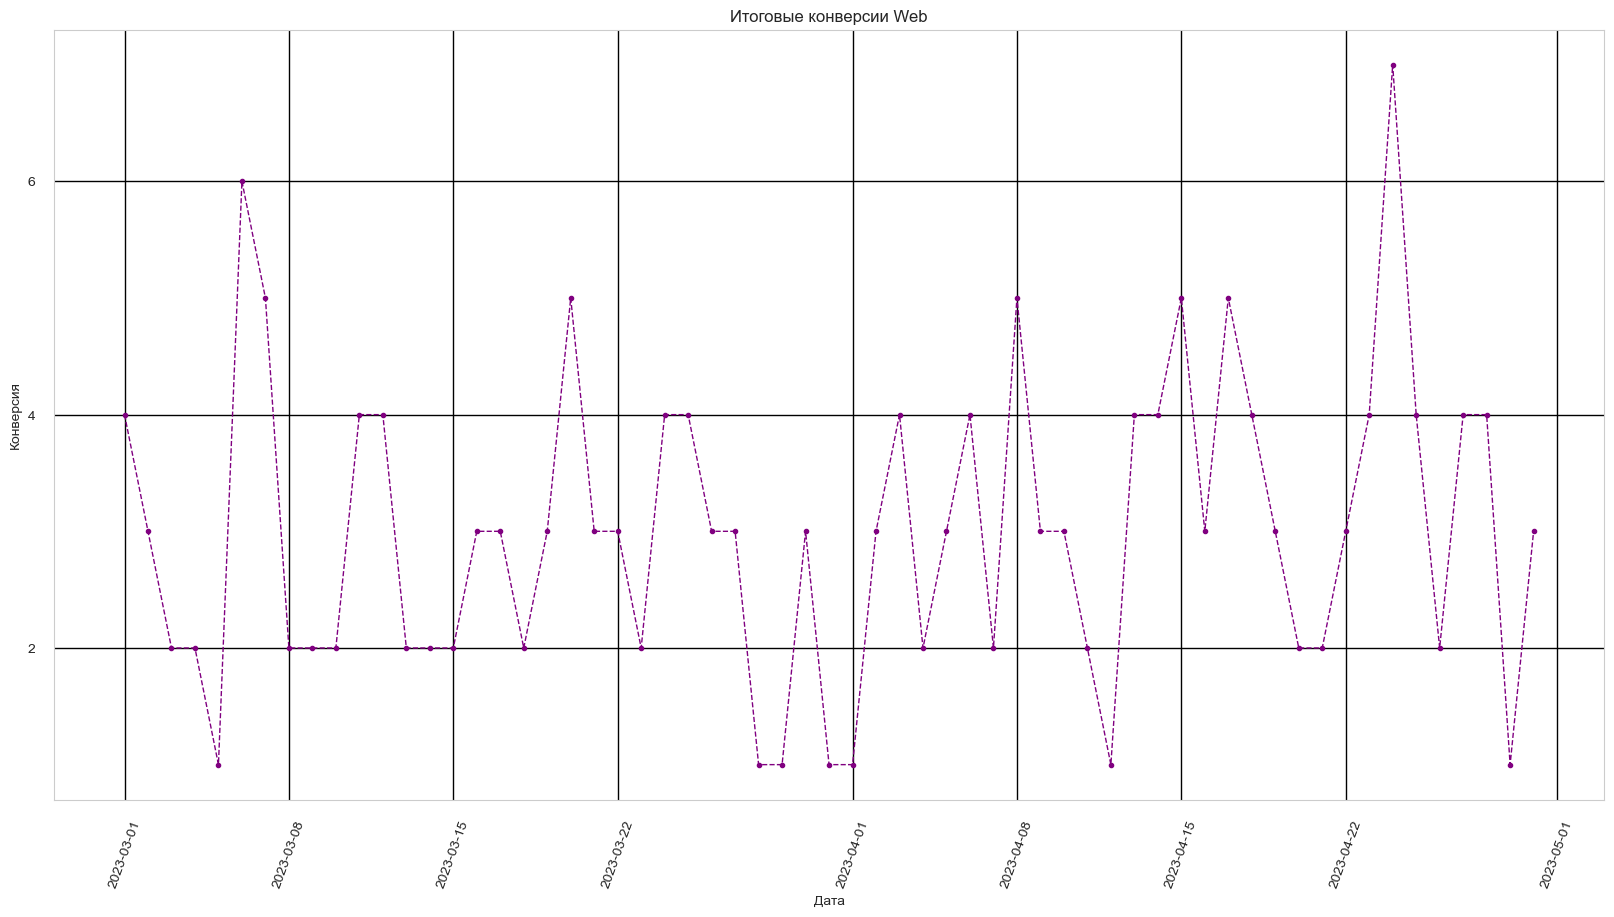

In [24]:
visits_and_registrations_web = visits_and_registrations[visits_and_registrations['platform'] == 'web']
visits_and_registrations_web_two_months = visits_and_registrations_web[visits_and_registrations_web['date'] <= dt.date(2023, 4, 30)]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(visits_and_registrations_web_two_months['date'], visits_and_registrations_web_two_months['conversion'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Конверсия')
plt.title('Итоговые конверсии Web')
plt.xticks(rotation=70)

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter('{x:.0f}')

# ax.yaxis.set_minor_locator(MultipleLocator(0.5))
# ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=2, )

# for x, y in zip(total_conversion_two_months['date'], total_conversion_two_months['conversion']):
#     plt.text(x, y, '%d' % y, ha='center', va = 'bottom')
plt.show()

###### *Стоимость реклам*

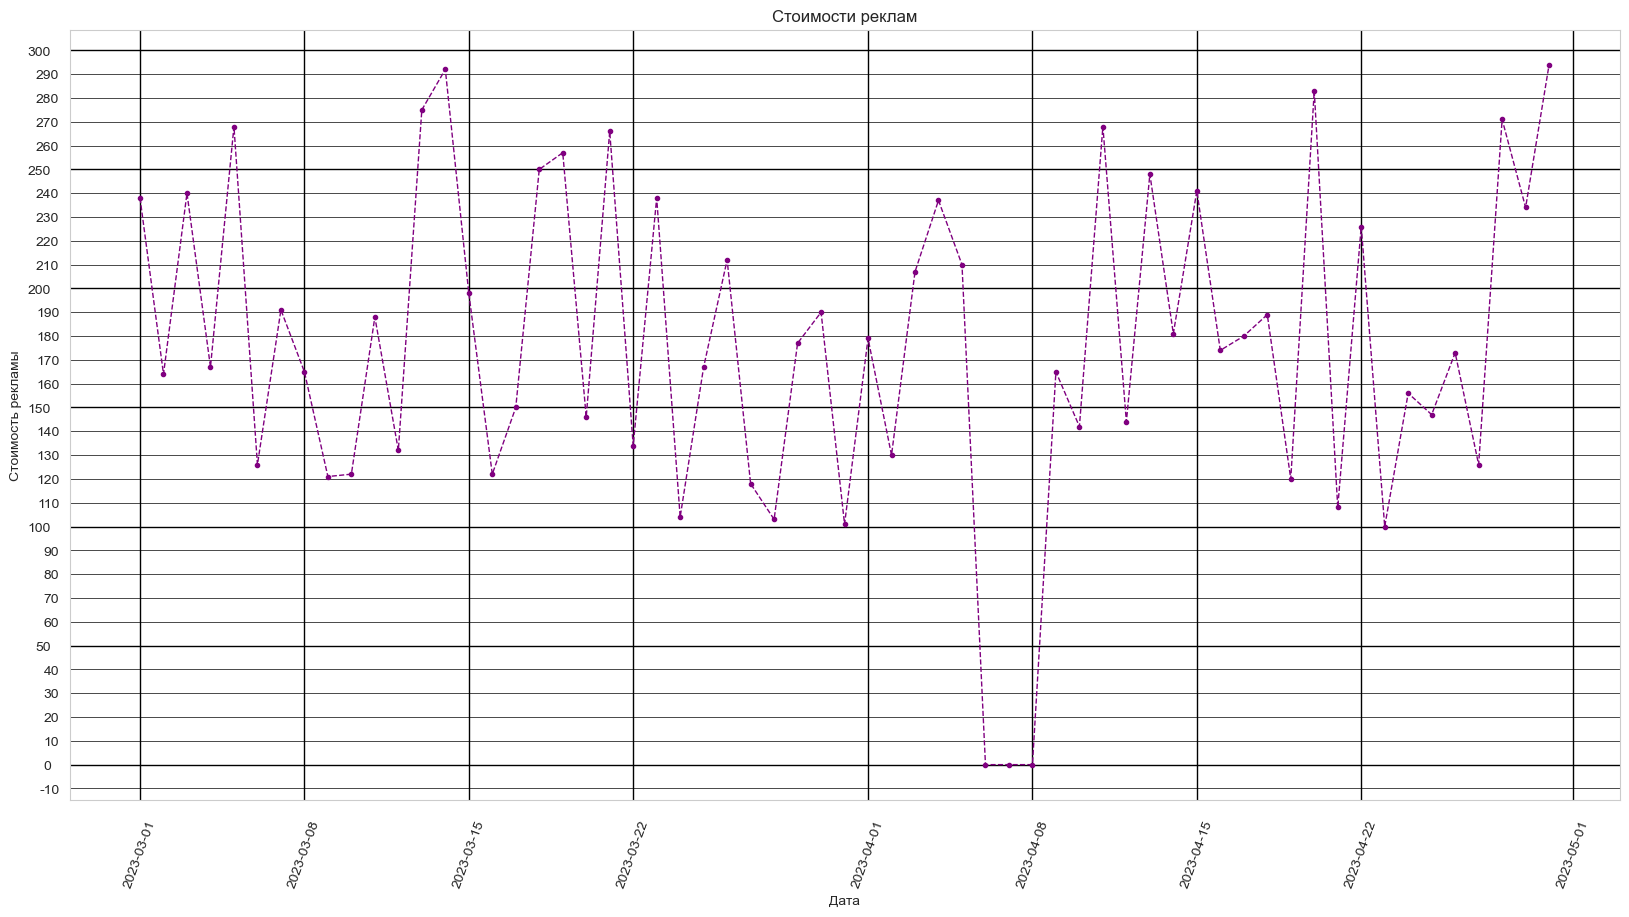

In [25]:
ads_per_day = ads.loc[::3, ['date_group', 'cost']]
ads_per_day_two_months = ads_per_day[ads_per_day['date_group'] <= dt.date(2023, 4, 30)]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(ads_per_day_two_months['date_group'], ads_per_day_two_months['cost'],
        color='purple',
        marker='o',
        linestyle='dashed',
        linewidth=1,
        markersize=3)
ax.grid()
ax.set_xlabel('Дата')
ax.set_ylabel('Стоимость рекламы')
plt.title('Стоимости реклам')
plt.xticks(rotation=70)

ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter('{x:.0f}')

ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_formatter('{x:.0f}')

ax.grid(which='major', color='black', linewidth=1)
ax.grid(which='minor', color='black', linewidth=0.5)

ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=4, )

###### *Визиты с выделением рекламных кампаний*

In [120]:
visits_from_utm_campaign = ads.groupby(['date_group', 'utm_campaign']).agg({'visits':'sum'}).reset_index()
visits_from_utm_campaign_two_months = visits_from_utm_campaign[visits_from_utm_campaign['date_group'] < dt.date(2023, 4, 30)]
print(visits_from_utm_campaign_two_months.head(10))

   date_group              utm_campaign  visits
0  2023-03-01  virtual_reality_workshop     675
1  2023-03-02  virtual_reality_workshop     671
2  2023-03-03  virtual_reality_workshop    1529
3  2023-03-04  virtual_reality_workshop    2083
4  2023-03-05  virtual_reality_workshop    2321
5  2023-03-06  virtual_reality_workshop    2597
6  2023-03-07  virtual_reality_workshop    2938
7  2023-03-08  virtual_reality_workshop    2484
8  2023-03-09  virtual_reality_workshop    2126
9  2023-03-10  virtual_reality_workshop    2865


###### *Регистрации с выделением рекламных кампаний*

In [121]:
registrations_from_utm_campaign = ads.groupby(['date_group', 'utm_campaign']).agg({'registrations':'sum'}).reset_index()
registrations_from_utm_campaign_two_months = registrations_from_utm_campaign[registrations_from_utm_campaign['date_group'] < dt.date(2023, 4, 30)]
print(registrations_from_utm_campaign_two_months.head(10))

   date_group              utm_campaign  registrations
0  2023-03-01  virtual_reality_workshop            363
1  2023-03-02  virtual_reality_workshop            219
2  2023-03-03  virtual_reality_workshop            338
3  2023-03-04  virtual_reality_workshop            278
4  2023-03-05  virtual_reality_workshop            362
5  2023-03-06  virtual_reality_workshop            665
6  2023-03-07  virtual_reality_workshop            572
7  2023-03-08  virtual_reality_workshop            484
8  2023-03-09  virtual_reality_workshop            218
9  2023-03-10  virtual_reality_workshop            442
